In [1]:
import bioframe
import pandas as pd
import numpy as np
import tensorflow as tf
from basenji import dna_io
import akita_utils

import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 13})

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  

2022-11-07 15:11:49.365560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /spack/apps/linux-centos7-x86_64/gcc-8.3.0/python-3.9.2-uvcroioc4witkp6qf7mbebof5ix4wlb6/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/pmix-3.1.3-3sm6emyqaxapunh7rwbjvtaqoqe2e5z3/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openmpi-4.0.2-ipm3dnvlbtxawpi4ifz7jma6jgr7mexq/lib:/spack/apps/linux-centos7-x86_64/gcc-8.3.0/openblas-0.3.8-2no6mfziiclwxb7lstxoos335gnhjpes/lib:/spack/apps/gcc/8.3.0/lib64::/home1/smaruj/software/GSL/lib:/home1/smaruj/software/HTSLIB/lib
2022-11-07 15:11:49.365599: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
common_path = "/home1/smaruj/akita_utils/bin/insert_virtual_spacing_experiment/data/"

left_filename_bg12 = "left_0.5Mb_strong100_bg12.h5"
left_filename_bg34 = "left_0.5Mb_strong100_bg34.h5"
right_filename_bg12 = "right_0.5Mb_strong100_bg12.h5"
right_filename_bg34 = "right_0.5Mb_strong100_bg34.h5"
convergent_filename_bg12 = "convergent_0.5Mb_strong100_bg12.h5"
convergent_filename_bg34 = "convergent_0.5Mb_strong100_bg34.h5"
divergent_filename_bg12 = "divergent_0.5Mb_strong100_bg12.h5"
divergent_filename_bg34 = "divergent_0.5Mb_strong100_bg34.h5"

In [3]:
scd_stats = ["SCD", "INS-16"]
target_dict = {"0" : "mESC_uC",
              "1" : "mESC",
              "2" : "CN",
              "3" : "ncx_CN",
              "4" : "NPC",
              "5" : "ncx_NPC"}

In [4]:
left_df_bg12 = akita_utils.h5_to_df(common_path + left_filename_bg12, scd_stats, drop_duplicates_key=None)
left_df_bg34 = akita_utils.h5_to_df(common_path + left_filename_bg34, scd_stats, drop_duplicates_key=None)
right_df_bg12 = akita_utils.h5_to_df(common_path + right_filename_bg12, scd_stats, drop_duplicates_key=None)
right_df_bg34 = akita_utils.h5_to_df(common_path + right_filename_bg34, scd_stats, drop_duplicates_key=None)
convergent_df_bg12 = akita_utils.h5_to_df(common_path + convergent_filename_bg12, scd_stats, drop_duplicates_key=None)
convergent_df_bg34 = akita_utils.h5_to_df(common_path + convergent_filename_bg34, scd_stats, drop_duplicates_key=None)
divergent_df_bg12 = akita_utils.h5_to_df(common_path + divergent_filename_bg12, scd_stats, drop_duplicates_key=None)
divergent_df_bg34 = akita_utils.h5_to_df(common_path + divergent_filename_bg34, scd_stats, drop_duplicates_key=None)

In [5]:
frames = [left_df_bg12, left_df_bg34, right_df_bg12, right_df_bg34, convergent_df_bg12, convergent_df_bg34, divergent_df_bg12, divergent_df_bg34]

df = pd.concat(frames)

In [6]:
get_seq_index = lambda x : (x % 100)

df["seq_index"] = df["experiment_id"].apply(get_seq_index)

In [7]:
# x axis for all plots

spacing_list = list(np.unique(df["spacer_bp"]))
x = 2 * np.array(spacing_list) + 40

In [8]:
def average_over_targets(dataframe, stat, mouse=True, model=1):
    
    num_targets = 6
    if not mouse:
        num_targets = 5
    
    collist = [stat + f"_h{int(mouse)}_m{model}_t{i}" for i in range(num_targets)]
    
    dataframe[f"{stat}_average"] = dataframe[collist].mean(axis=1)
    
    return dataframe

In [9]:
for stat in scd_stats:
    df = average_over_targets(df, stat)

In [10]:
orientation_dict = {
    ">>" : {"strong_label" : "right",
            "line_style" : "-",
            "strong_1color" : "#4dac26",
            "weak_1color" : "#d01c8b",
            "orient_word" : "right"
        },
    "<<" : {"strong_label" : "left",
            "line_style" : "--",
            "strong_1color" : "#2166ac",
            "weak_1color" : "#f03b20",
            "orient_word" : "left"
        },
    "<>" : {"strong_label" : "divergent",
            "line_style" : "-.",
            "strong_1color" : "#fc7a02",
            "weak_1color" : "#636363",
            "orient_word" : "divergent"
        },
    "><" : {"strong_label" : "convergent",
            "line_style" : ":",
            "strong_1color" : "#a819dd",
            "weak_1color" : "#000000",
            "orient_word" : "convergent"
        },
}

In [11]:
orientation_vs_spacing = df.groupby(["orientation", "spacer_bp"]).agg({"SCD_average": "mean"}).reset_index()

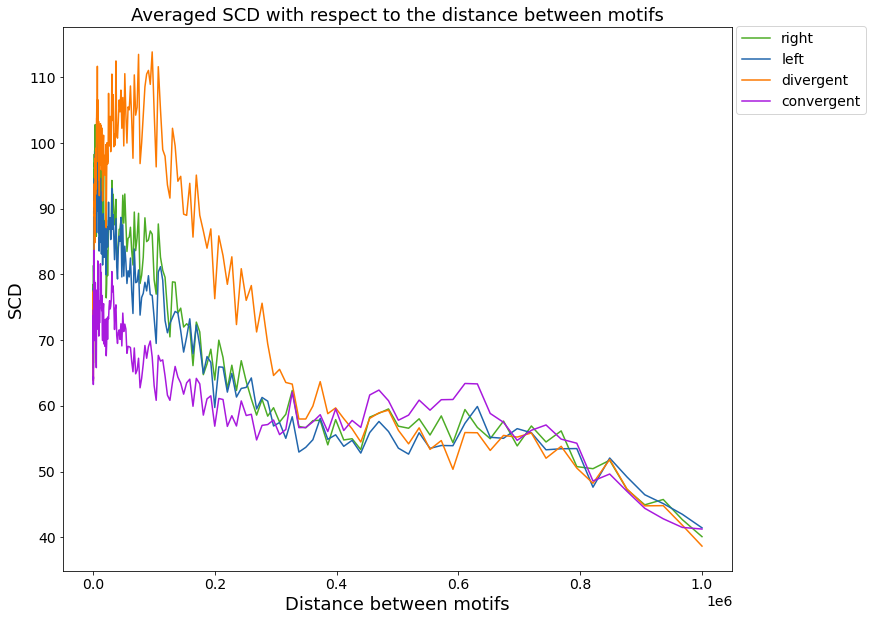

In [12]:
plt.figure(figsize=(12,10))

for key in orientation_dict:
    plt.plot(x, orientation_vs_spacing[orientation_vs_spacing["orientation"] == key]["SCD_average"], 
             label=orientation_dict[key]["strong_label"], 
             c=orientation_dict[key]["strong_1color"])

plt.title("Averaged SCD with respect to the distance between motifs")
plt.xlabel("Distance between motifs")
plt.ylabel("SCD")
plt.legend(bbox_to_anchor=(1.21, 1.015), loc='upper right', ncol=1)

plt.savefig("averaged_SCD.pdf", format="pdf", bbox_inches="tight")
plt.show()

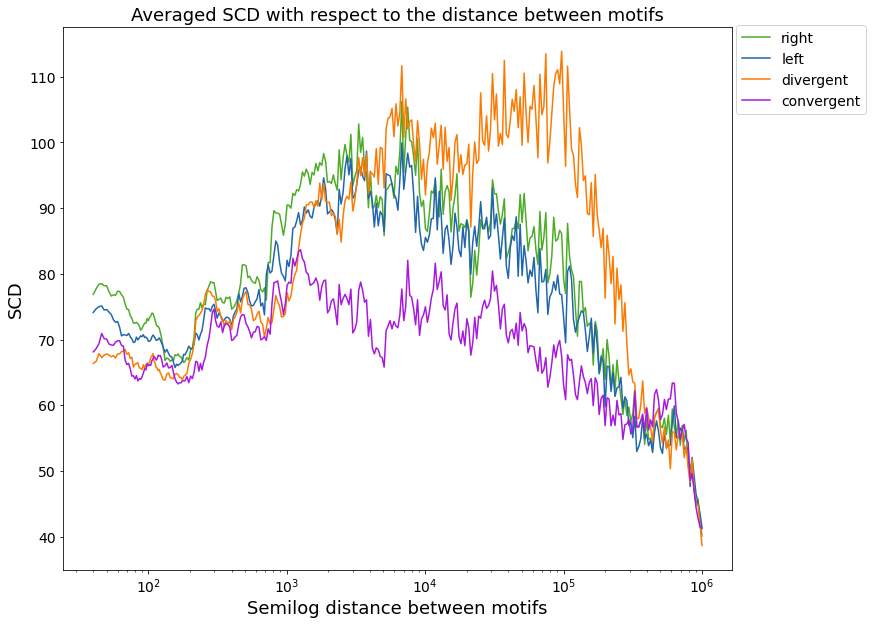

In [13]:
plt.figure(figsize=(12,10))

for key in orientation_dict:
    plt.semilogx(x, orientation_vs_spacing[orientation_vs_spacing["orientation"] == key]["SCD_average"], 
             label=orientation_dict[key]["strong_label"], 
             c=orientation_dict[key]["strong_1color"])

plt.title("Averaged SCD with respect to the distance between motifs")
plt.xlabel("Semilog distance between motifs")
plt.ylabel("SCD")
plt.legend(bbox_to_anchor=(1.21, 1.015), loc='upper right', ncol=1)

plt.savefig("averaged_semilog_SCD.pdf", format="pdf", bbox_inches="tight")
plt.show()

# smoothed version

In [14]:
from cooltools.lib import numutils

In [15]:
bin_size = 19

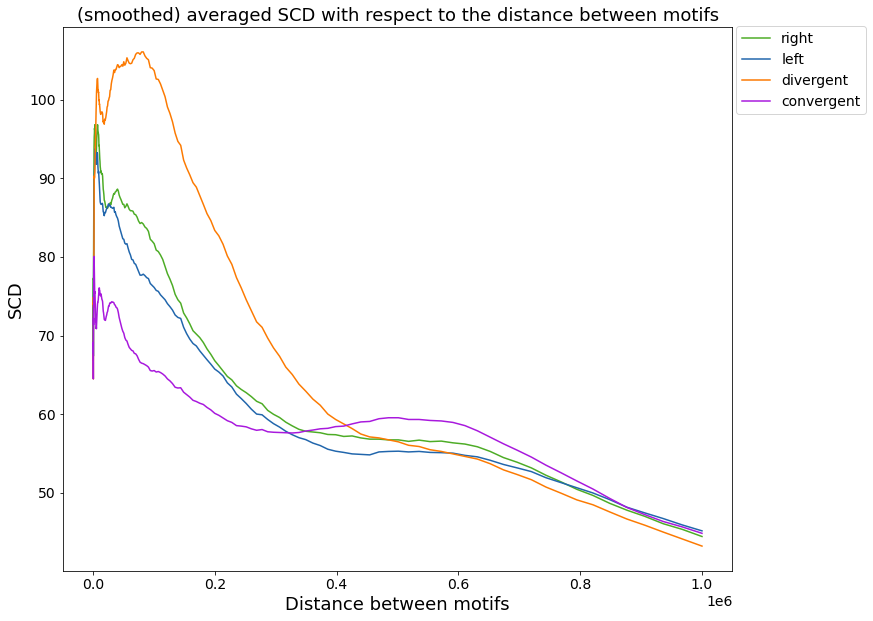

In [16]:
plt.figure(figsize=(12,10))

for key in orientation_dict:
    plt.plot(x, numutils.smooth(orientation_vs_spacing[orientation_vs_spacing["orientation"] == key]["SCD_average"], bin_size),
             label=orientation_dict[key]["strong_label"], 
             c=orientation_dict[key]["strong_1color"])

plt.title("(smoothed) averaged SCD with respect to the distance between motifs")
plt.xlabel("Distance between motifs")
plt.ylabel("SCD")

plt.legend(bbox_to_anchor=(1.21, 1.015), loc='upper right', ncol=1)
plt.savefig("smoothed_averaged_SCD.pdf", format="pdf", bbox_inches="tight")
plt.show()

# with percentiles band

In [17]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [18]:
SCDpercentiles_df = df.groupby(["orientation", "spacer_bp"])["SCD_average"].agg(
    percentile25 = percentile(25), percentile75 = percentile(75)).reset_index()

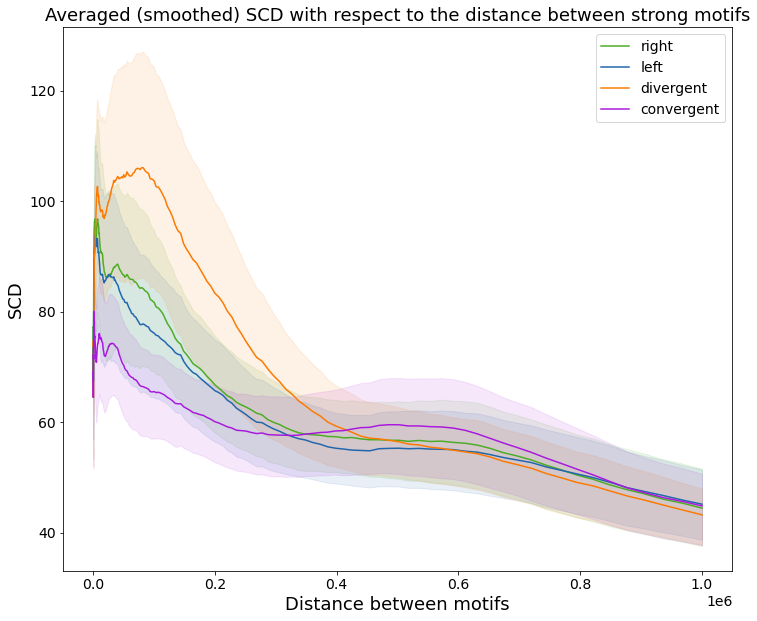

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))

for key in orientation_dict:
    ax.plot(x, numutils.smooth(orientation_vs_spacing[orientation_vs_spacing["orientation"] == key]["SCD_average"], bin_size),
             label=orientation_dict[key]["strong_label"], 
             c=orientation_dict[key]["strong_1color"])
    
    percentile25_line = numutils.smooth(SCDpercentiles_df[SCDpercentiles_df["orientation"] == key]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(SCDpercentiles_df[SCDpercentiles_df["orientation"] == key]["percentile75"], bin_size)
    
    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.1, color=orientation_dict[key]["strong_1color"])    

plt.title("Averaged (smoothed) SCD with respect to the distance between strong motifs")
plt.xlabel("Distance between motifs")
plt.ylabel("SCD")
plt.legend(loc="upper right")

plt.savefig("27_75percentiles_averaged_SCD.pdf", format="pdf", bbox_inches="tight")
plt.show()

# backgrounds

In [20]:
background_vs_orientation_vs_spacings = df.groupby(["background_index", "orientation", "spacer_bp"]).agg({"SCD_average": "mean"}).reset_index()

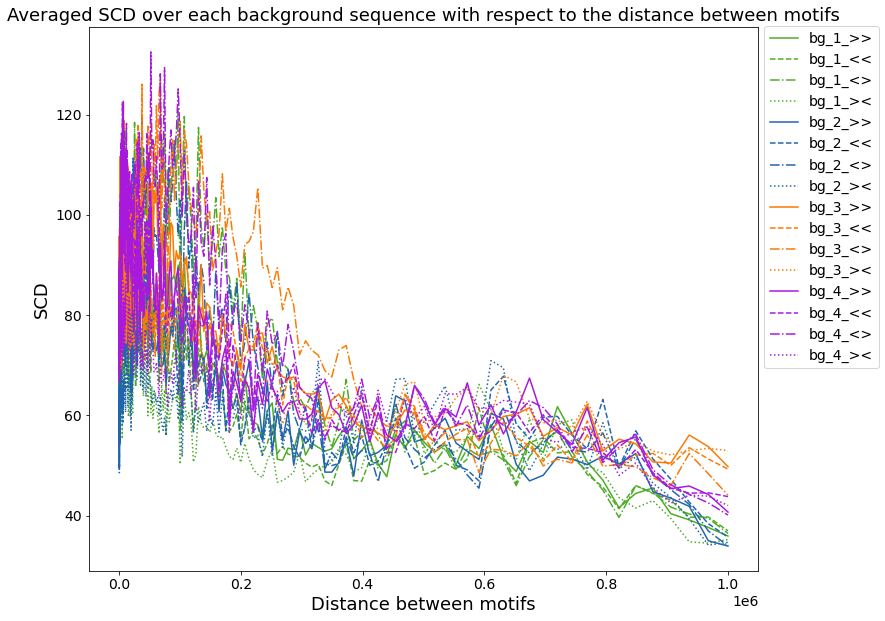

In [21]:
background_colors = ["#4dac26", "#2166ac", "#fc7a02", "#a819dd"]

plt.figure(figsize=(12,10))

for background_idx in [1, 2, 3, 4]:
    for key in orientation_dict:
        plt.plot(x, background_vs_orientation_vs_spacings[(background_vs_orientation_vs_spacings["background_index"] == background_idx) & (background_vs_orientation_vs_spacings["orientation"] == key)]["SCD_average"], 
                 orientation_dict[key]["line_style"],
                 c=background_colors[background_idx-1],
                 label=f"bg_{background_idx}_{key}")

plt.legend(loc="upper right")
plt.title("Averaged SCD over each background sequence with respect to the distance between motifs")
plt.xlabel("Distance between motifs")
plt.ylabel("SCD")

plt.legend(bbox_to_anchor=(1.19, 1.015), loc='upper right', ncol=1)
plt.savefig("backgrounds_SCD.pdf", format="pdf", bbox_inches="tight")
plt.show()

# taking median over backgrounds

In [22]:
columns_to_take_median = ["INS-16_h1_m1_t0", "INS-16_h1_m1_t1", "INS-16_h1_m1_t2", "INS-16_h1_m1_t3", "INS-16_h1_m1_t4", "INS-16_h1_m1_t5",
                          "SCD_h1_m1_t0", "SCD_h1_m1_t1", "SCD_h1_m1_t2", "SCD_h1_m1_t3", "SCD_h1_m1_t4", "SCD_h1_m1_t5",
                          "SCD_average", "INS-16_average"]
median_list = ["median" for i in range(len(columns_to_take_median))]

dictionary_to_median = dict(zip(columns_to_take_median, median_list))

In [23]:
new_df = df.groupby(["orientation","spacer_bp", "seq_index"]).agg(dictionary_to_median).reset_index()

# targets

In [24]:
strong_targets = ["#F20808", "#1119EF", "#09DAE9", "#13F238", "#EC9018", "#E80ACA"]
weak_targets = ["#E65A5A", "#7B7EDB", "#AAEAEF", "#98F0A7", "#EEBE80", "#E69FDD"]

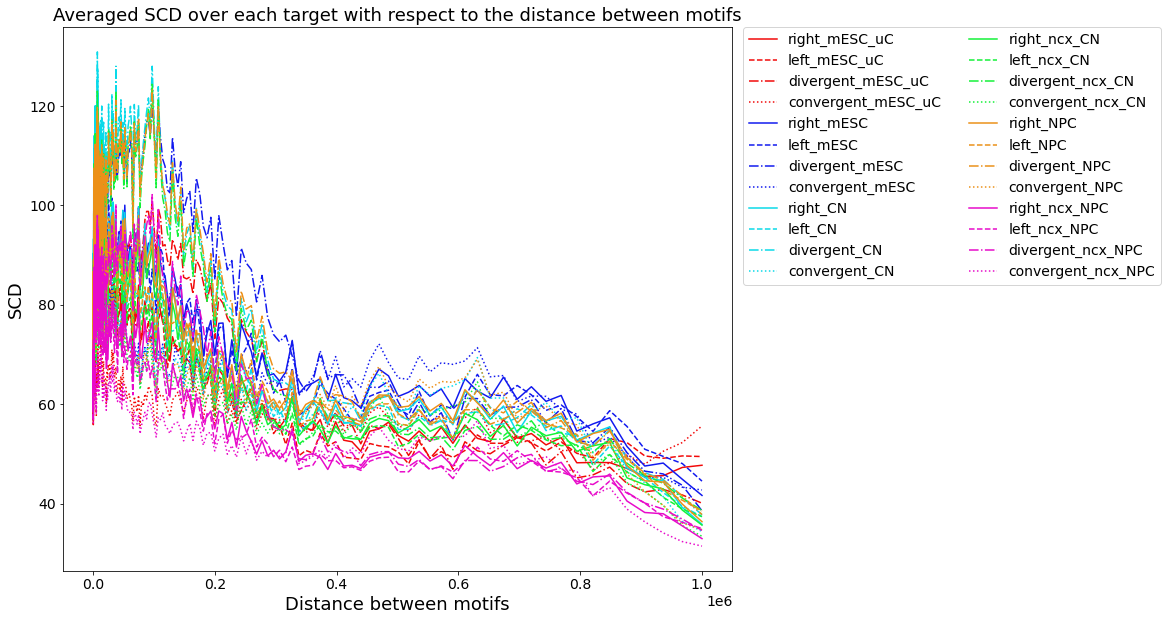

In [25]:
plt.figure(figsize=(12,10))

for target_idx in range(6):
    target_vs_orientation_spacer = new_df.groupby(["orientation", "spacer_bp"]).agg({f"SCD_h1_m1_t{target_idx}": "mean"}).reset_index()
    for key in orientation_dict:
        plt.plot(x, target_vs_orientation_spacer[target_vs_orientation_spacer["orientation"] == key][f"SCD_h1_m1_t{target_idx}"],
                 orientation_dict[key]["line_style"],
                 label=orientation_dict[key]["strong_label"] + f"_{target_dict[str(target_idx)]}", 
                 c=strong_targets[target_idx])
    
plt.title("Averaged SCD over each target with respect to the distance between motifs")
plt.xlabel("Distance between motifs")
plt.ylabel("SCD")

plt.legend(bbox_to_anchor=(1.65, 1.013), loc='upper right', ncol=2)
plt.savefig("targets_SCD.pdf", format="pdf", bbox_inches="tight")
plt.show()

# data heterogenity

In [26]:
orientation_vs_spacer_sequence = new_df.groupby(["orientation", "seq_index", "spacer_bp"]).agg({"SCD_average": "mean"}).reset_index()

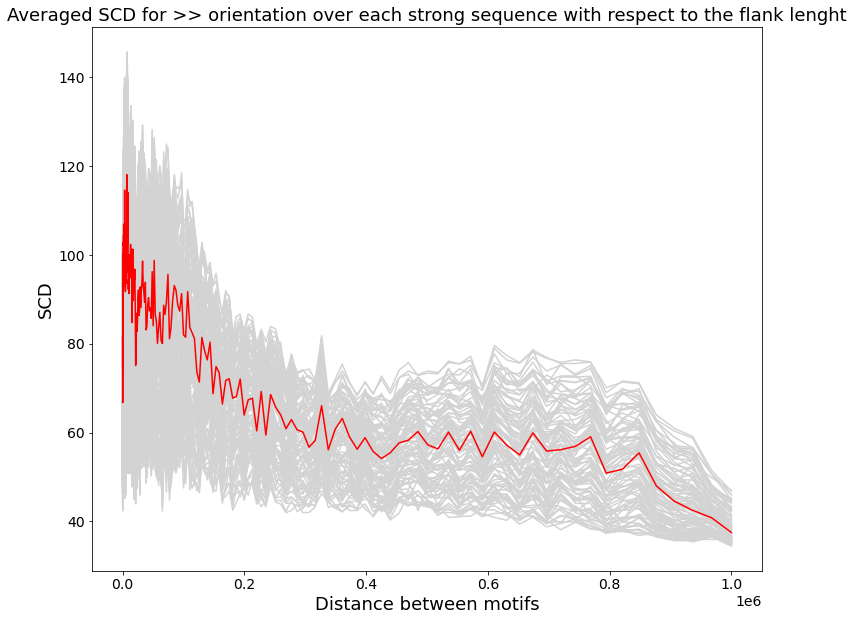

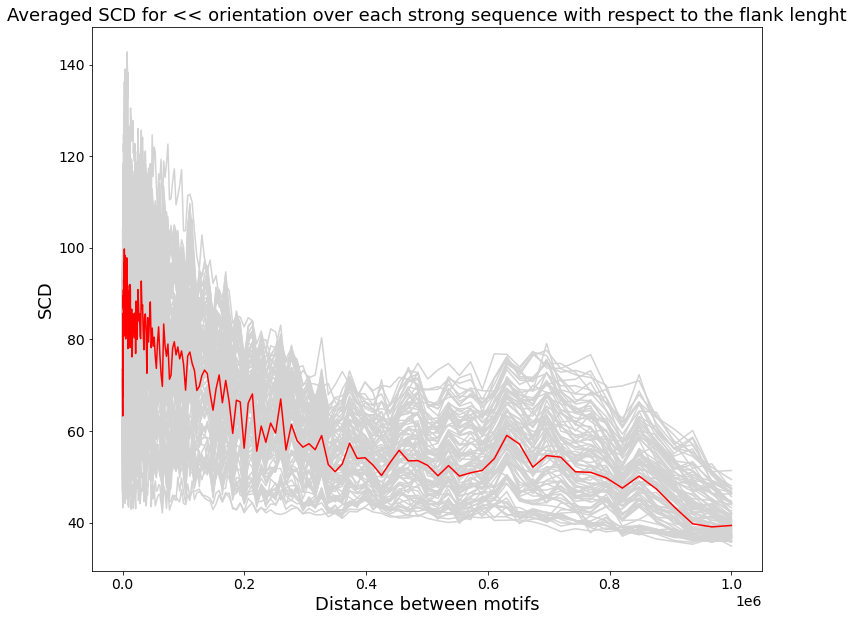

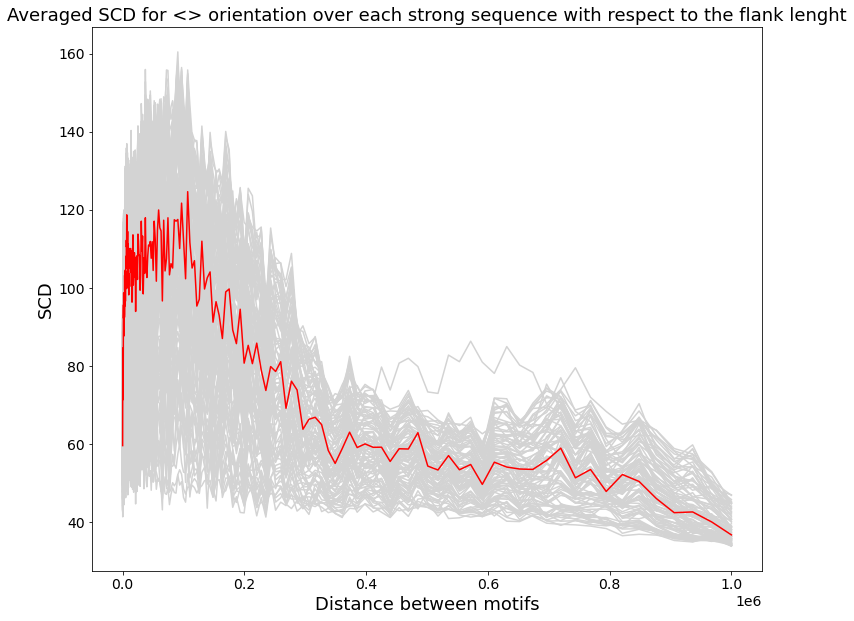

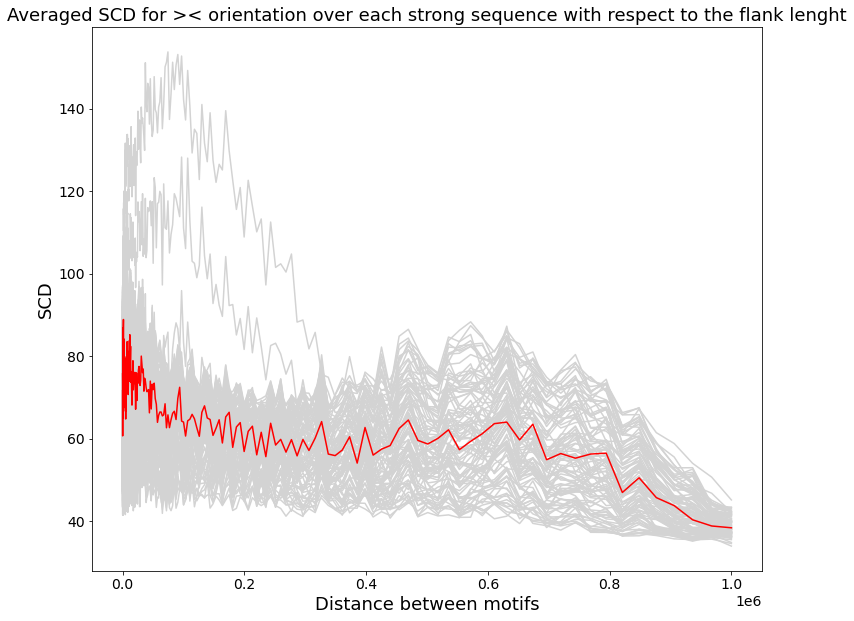

In [27]:
for key in orientation_dict:
    helper_df = orientation_vs_spacer_sequence[(orientation_vs_spacer_sequence["orientation"] == key) & (orientation_vs_spacer_sequence["spacer_bp"] == spacing_list[-1])]
    median_seq_idx = helper_df.loc[helper_df["SCD_average"] > helper_df["SCD_average"].median()].sort_values(by=["SCD_average"]).iloc[0]["seq_index"]
    
    orient = orientation_vs_spacer_sequence[orientation_vs_spacer_sequence["orientation"] == key]
    
    plt.figure(figsize=(12,10))

    for seq_idx in range(100):

        if seq_idx != median_seq_idx:
            plt.plot(x, orient[orient["seq_index"] == seq_idx]["SCD_average"], c="lightgray")
    
    # visializing any sequence of a known index
    # plt.plot(x, orient[orient["seq_index"] == 10]["SCD_average"], c="green")
    
    plt.plot(x, orient[orient["seq_index"] == median_seq_idx]["SCD_average"], c="red")
    
    plt.title(f"Averaged SCD for {key} orientation over each strong sequence with respect to the flank lenght")
    plt.xlabel("Distance between motifs")
    plt.ylabel("SCD")
    
    orient_word = orientation_dict[key]["orient_word"]
    plt.savefig(f"100sequences_SCD_{orient_word}.pdf", format="pdf", dpi=400)

# subtracting starting SCD values

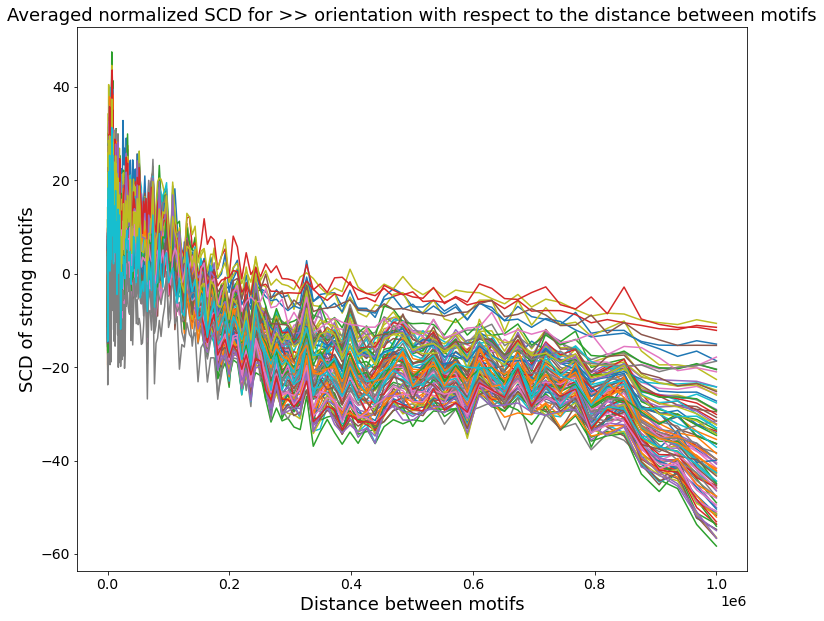

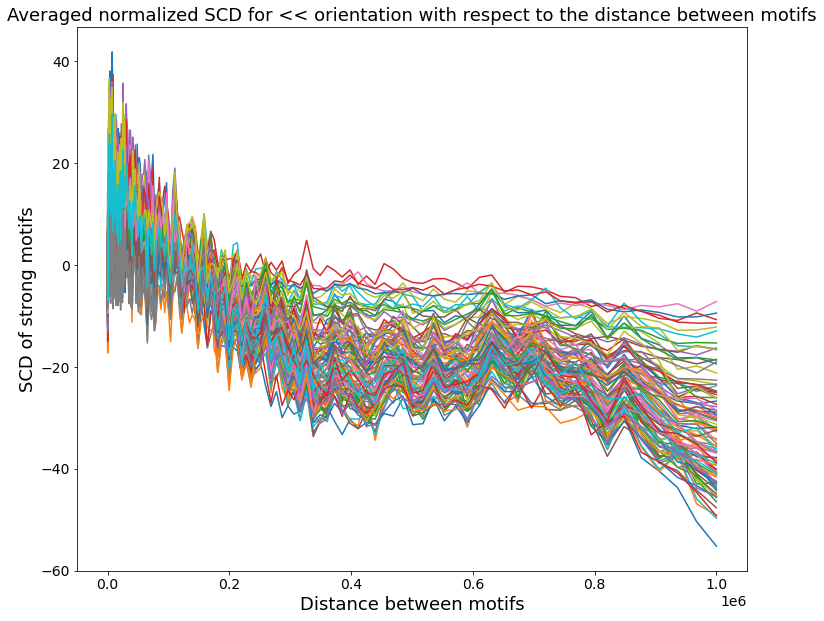

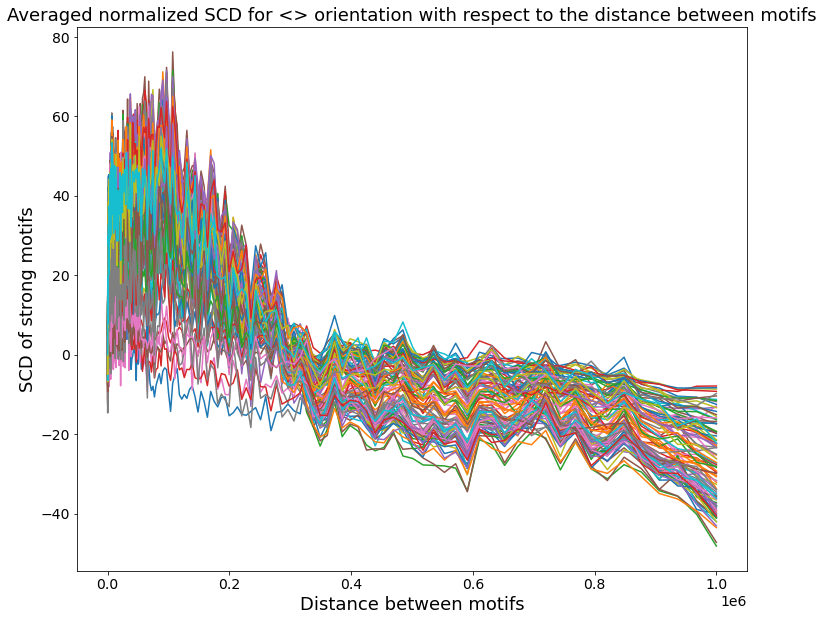

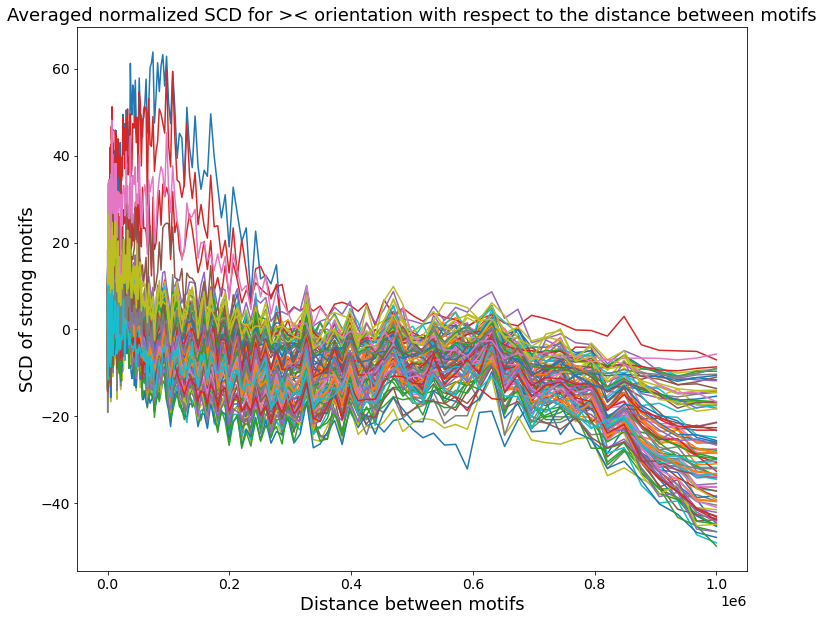

In [28]:
for key in orientation_dict:
    
    orient = orientation_vs_spacer_sequence[orientation_vs_spacer_sequence["orientation"] == key]
    
    plt.figure(figsize=(12,10))

    for seq_idx in range(100):

        initial_SCD_value = orient[(orient["seq_index"] == seq_idx) & (orient["spacer_bp"] == 0)]["SCD_average"]
        
        plt.plot(x, orient[orient["seq_index"] == seq_idx]["SCD_average"] - float(initial_SCD_value))
    
    plt.title(f"Averaged normalized SCD for {key} orientation with respect to the distance between motifs")
    plt.xlabel("Distance between motifs")
    plt.ylabel("SCD of strong motifs")
    # plt.savefig(f"sequences_normalized_SCD_{key}.png", bbox_inches="tight")

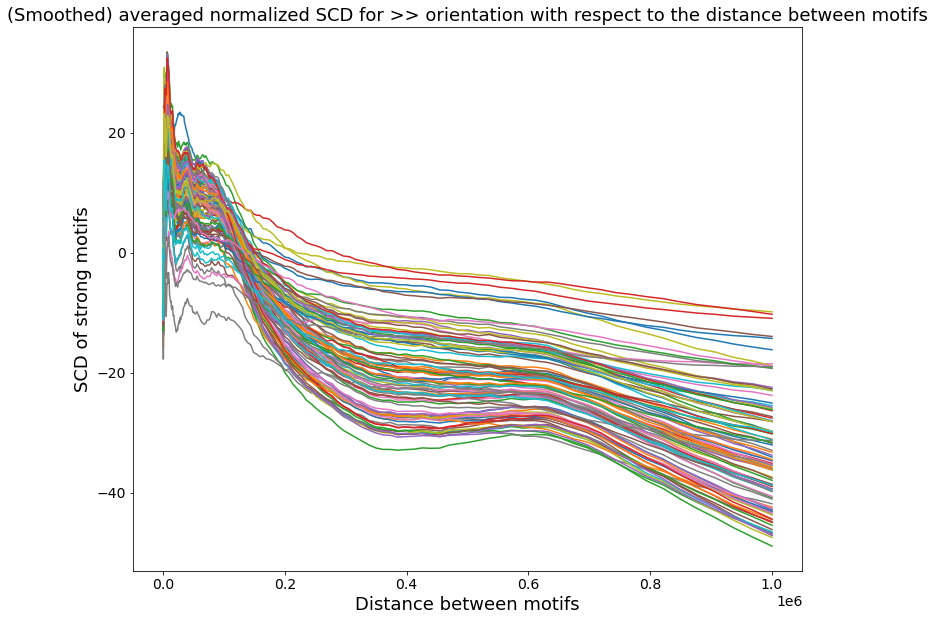

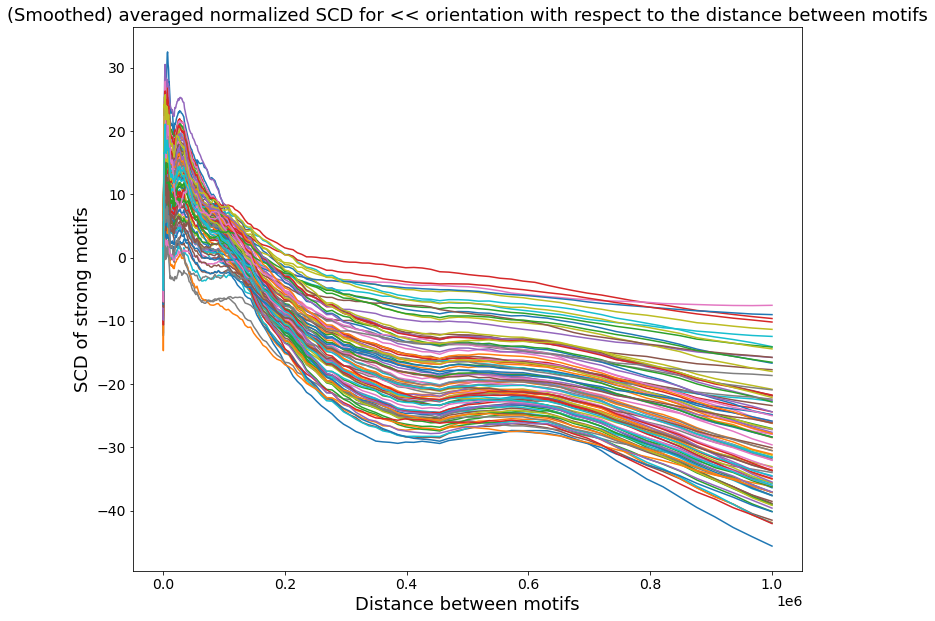

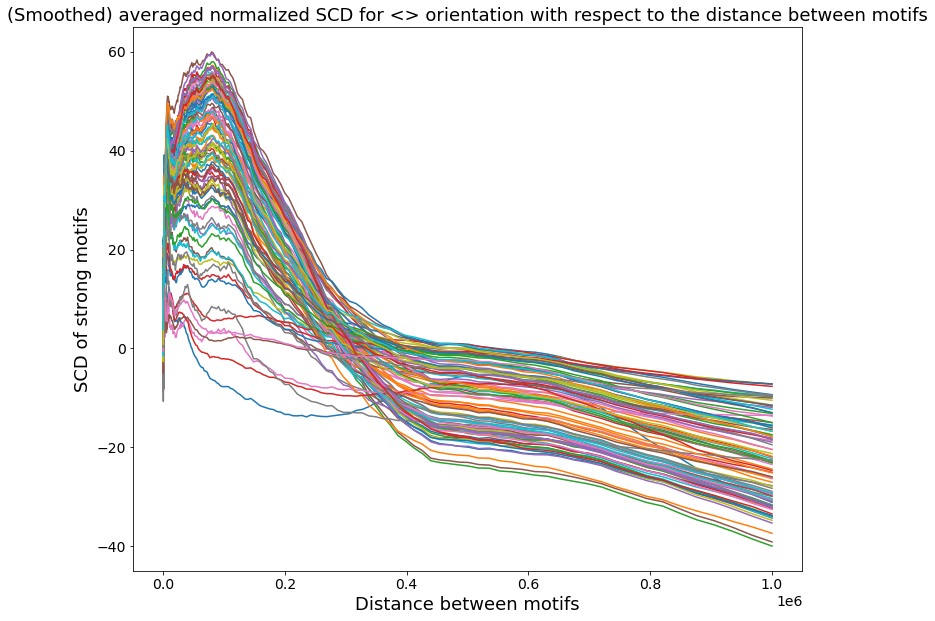

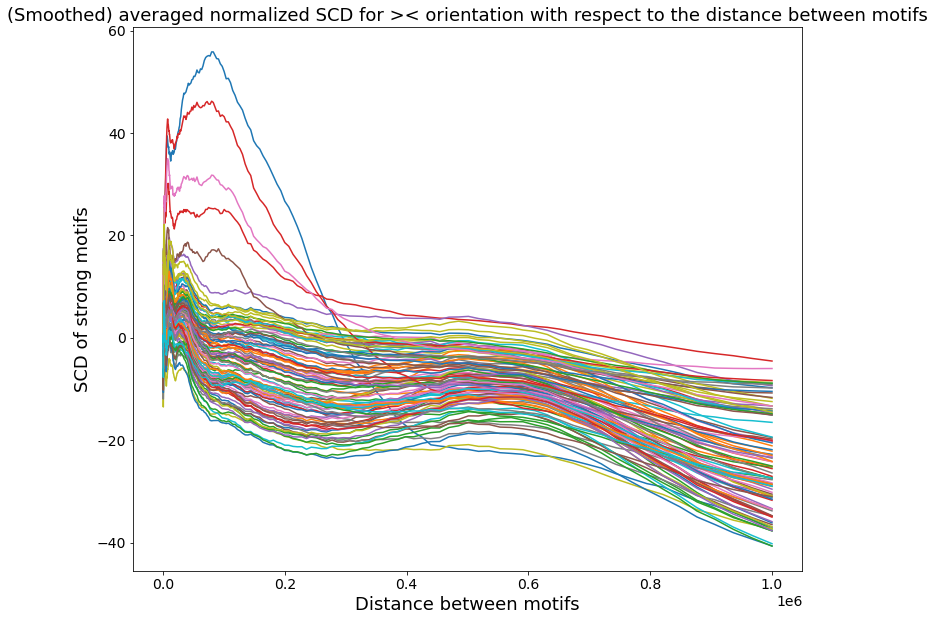

In [29]:
for key in orientation_dict:
    
    orient = orientation_vs_spacer_sequence[orientation_vs_spacer_sequence["orientation"] == key]    
    plt.figure(figsize=(12,10))

    for seq_idx in range(100):

        initial_SCD_value = orient[(orient["seq_index"] == seq_idx) & (orient["spacer_bp"] == 0)]["SCD_average"]
        
        plt.plot(x, numutils.smooth(orient[orient["seq_index"] == seq_idx]["SCD_average"] - float(initial_SCD_value), bin_size))
    
    plt.title(f"(Smoothed) averaged normalized SCD for {key} orientation with respect to the distance between motifs")
    plt.xlabel("Distance between motifs")
    plt.ylabel("SCD of strong motifs")
    # plt.savefig(f"sequences_normalized_smoothed_SCD_{key}.png", bbox_inches="tight")

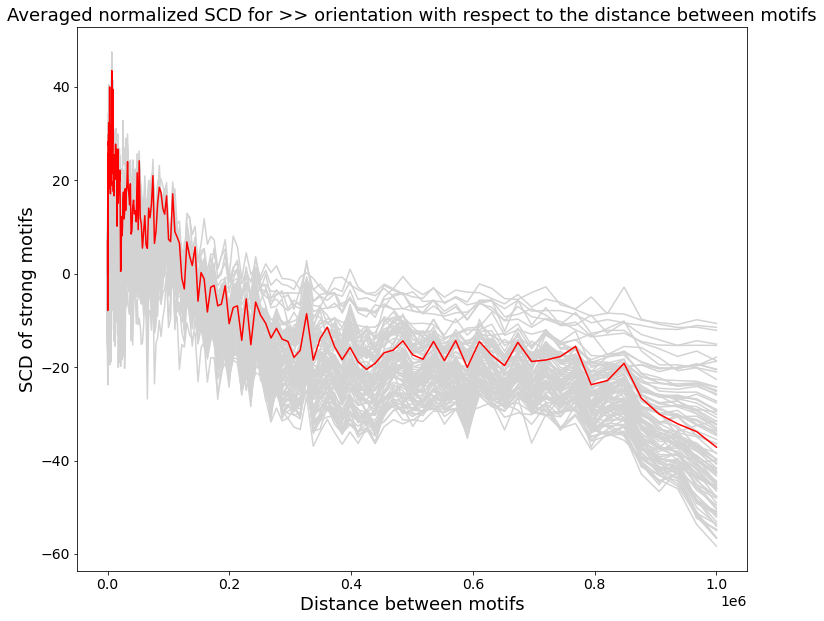

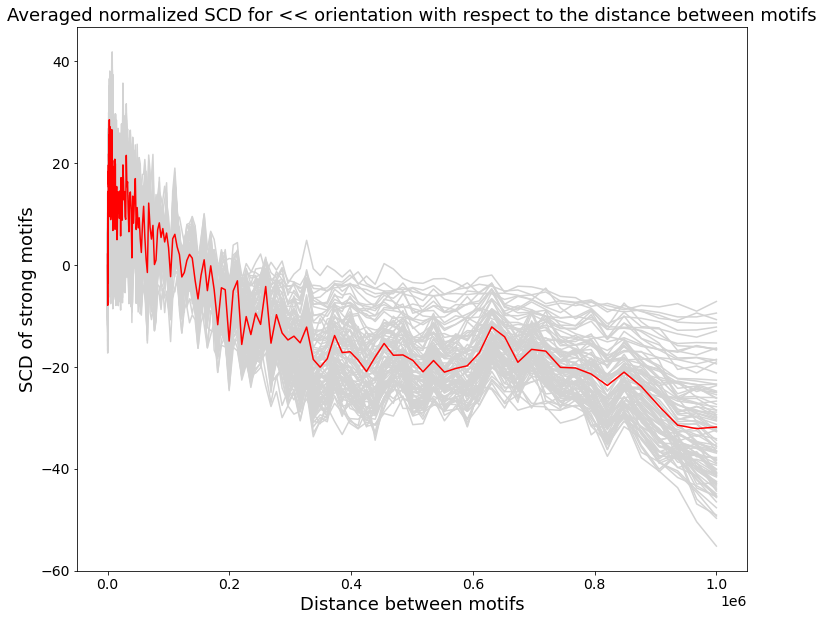

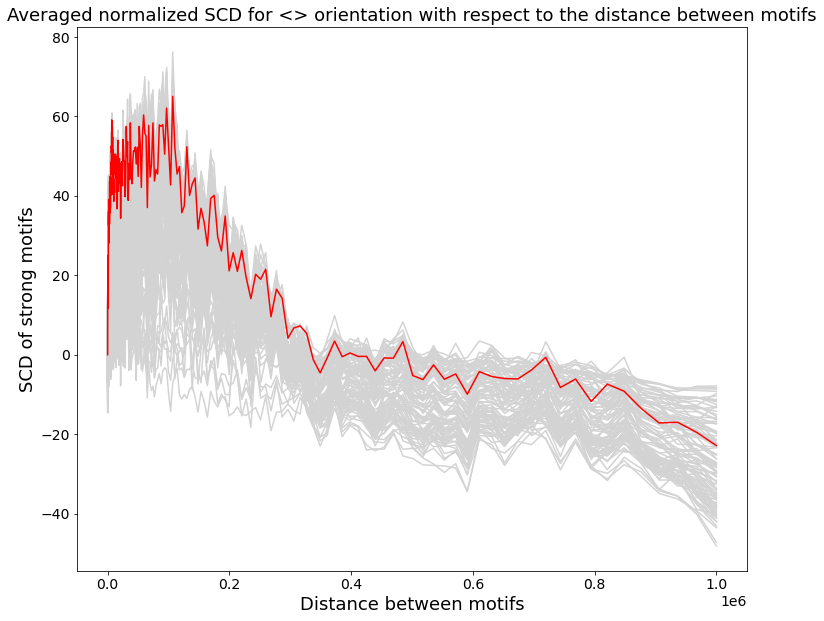

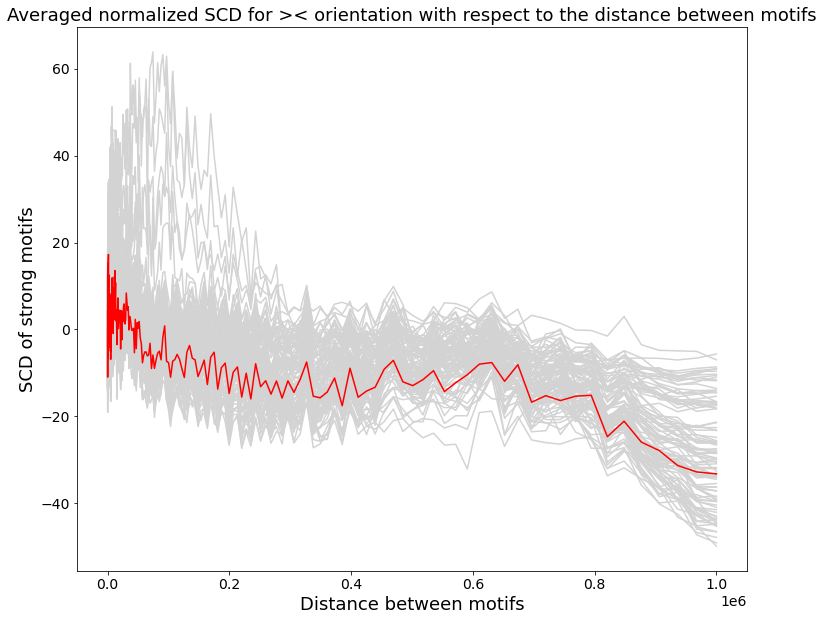

In [30]:
for key in orientation_dict:
    helper_df = orientation_vs_spacer_sequence[(orientation_vs_spacer_sequence["orientation"] == key) & (orientation_vs_spacer_sequence["spacer_bp"] == spacing_list[-1])]
    median_seq_idx = helper_df.loc[helper_df["SCD_average"] > helper_df["SCD_average"].median()].sort_values(by=["SCD_average"]).iloc[0]["seq_index"]
    
    orient = orientation_vs_spacer_sequence[orientation_vs_spacer_sequence["orientation"] == key]
    
    plt.figure(figsize=(12,10))

    for seq_idx in range(100):
        if seq_idx != median_seq_idx:
            initial_SCD_value = orient[(orient["seq_index"] == seq_idx) & (orient["spacer_bp"] == 0)]["SCD_average"]
            plt.plot(x, orient[orient["seq_index"] == seq_idx]["SCD_average"] - float(initial_SCD_value), c="lightgray")
    
    median_initial_SCD_value = orient[(orient["seq_index"] == median_seq_idx) & (orient["spacer_bp"] == 0)]["SCD_average"]
    plt.plot(x, orient[orient["seq_index"] == median_seq_idx]["SCD_average"] - float(median_initial_SCD_value), c="red")
    
    plt.title(f"Averaged normalized SCD for {key} orientation with respect to the distance between motifs")
    plt.xlabel("Distance between motifs")
    plt.ylabel("SCD of strong motifs")
    # plt.savefig(f"median_sequences_normalized_SCD_{key}.png", bbox_inches="tight")

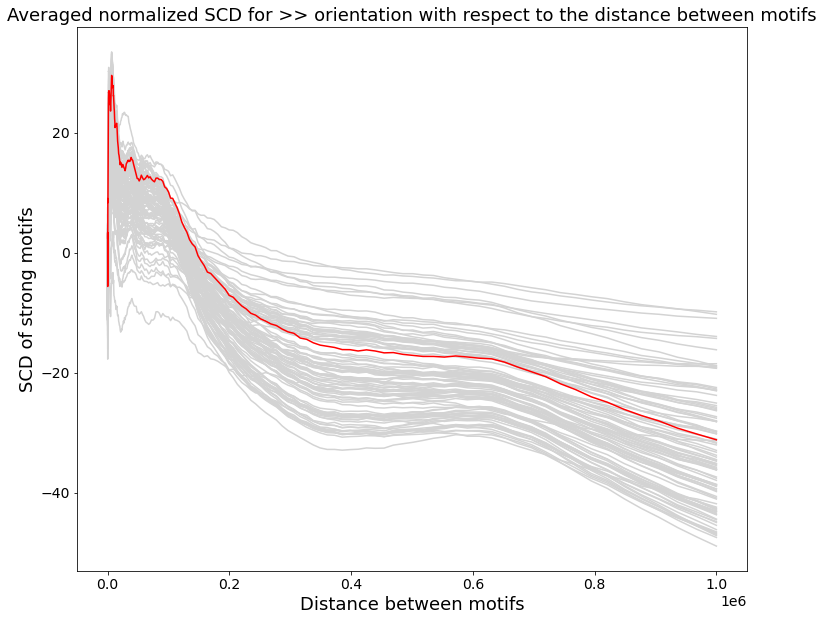

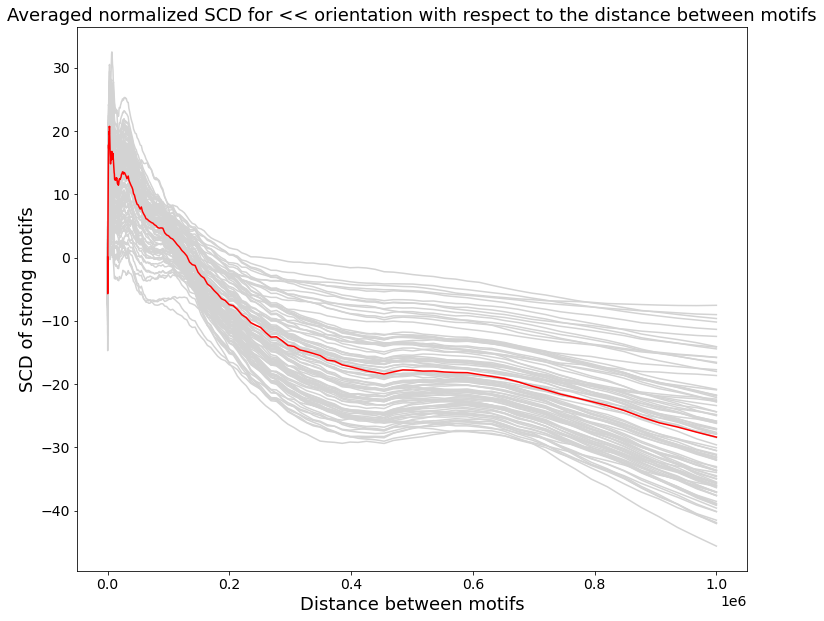

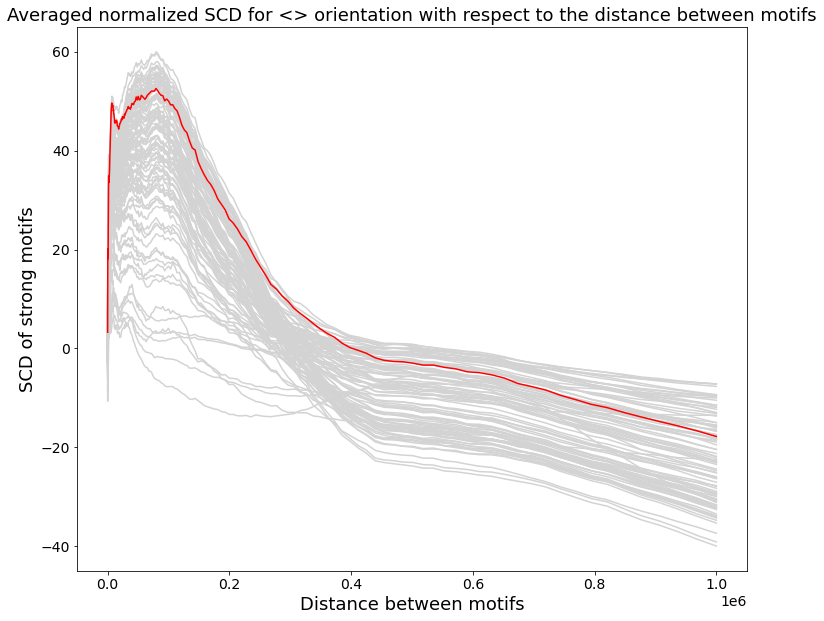

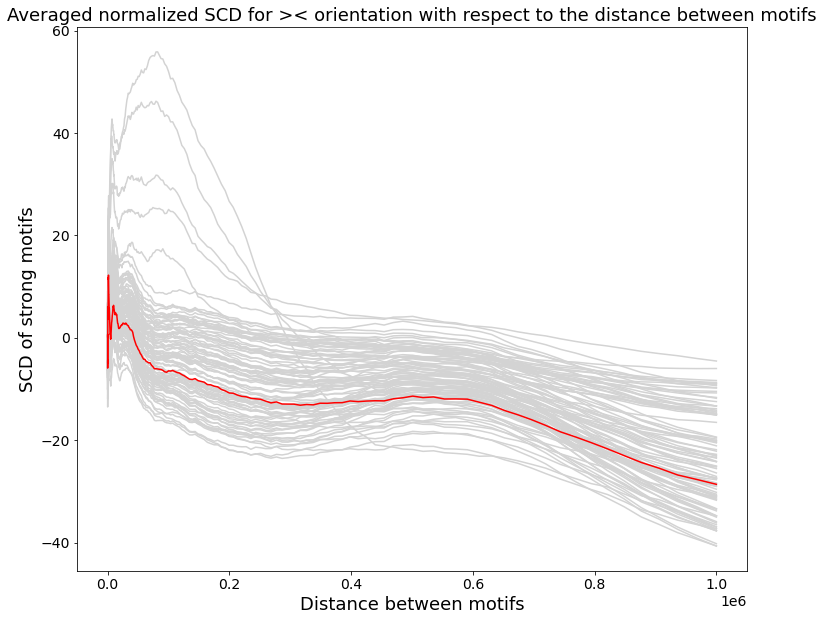

In [31]:
for key in orientation_dict:
    helper_df = orientation_vs_spacer_sequence[(orientation_vs_spacer_sequence["orientation"] == key) & (orientation_vs_spacer_sequence["spacer_bp"] == spacing_list[-1])]
    median_seq_idx = helper_df.loc[helper_df["SCD_average"] > helper_df["SCD_average"].median()].sort_values(by=["SCD_average"]).iloc[0]["seq_index"]
    
    orient = orientation_vs_spacer_sequence[orientation_vs_spacer_sequence["orientation"] == key]
    
    plt.figure(figsize=(12,10))

    for seq_idx in range(100):
        if seq_idx != median_seq_idx:
            initial_SCD_value = orient[(orient["seq_index"] == seq_idx) & (orient["spacer_bp"] == 0)]["SCD_average"]
            plt.plot(x, numutils.smooth((orient[orient["seq_index"] == seq_idx]["SCD_average"] - float(initial_SCD_value)), bin_size), c="lightgray")
    
    median_initial_SCD_value = orient[(orient["seq_index"] == median_seq_idx) & (orient["spacer_bp"] == 0)]["SCD_average"]
    plt.plot(x, numutils.smooth((orient[orient["seq_index"] == median_seq_idx]["SCD_average"] - float(median_initial_SCD_value)), bin_size), c="red")
    
    plt.title(f"Averaged normalized SCD for {key} orientation with respect to the distance between motifs")
    plt.xlabel("Distance between motifs")
    plt.ylabel("SCD of strong motifs")
    # plt.savefig(f"median_sequences_normalized_smoothed_SCD_{key}.png", bbox_inches="tight")